In [15]:

from igraph import Graph
import igraph as ig
import numpy as np
import json
import pandas as pd
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter
import scipy.sparse as sp
from torch.nn.modules.module import Module
from sklearn.metrics import classification_report
import torch.optim as optim
from torch.autograd import Variable
import time
import math
import neptune
import os
import random

seed=42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [16]:
seed=42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

node_list_path = r'C:\Users\George\Desktop\ISEF-2023\Datas\Node list\back up\current_protein_Signal+meta+targets.json'
with open(node_list_path, 'r') as file:
    node_list = json.load(file)
graph = r'C:\Users\George\Desktop\ISEF-2023\Network construction\PPI_homo_graph_features_loaded.graphml'
# Create an igraph object
PPI_graph = ig.Graph.Load(graph, format='graphml')

feature_keys = [
    "Indegree", "Outdegree", "Closeness", "Betweenness", "Pagerank", "Cluster_coefficients",
    "Nearest_Neighbor_Degree", "Similarity", "Subunit", "Transmembrane",
    "Catalytic_activity", "Interaction", "Tissue_Specificity", "Disease",
    "Sequence_conflict", "Modified_residue", "Function", "Binding_site",
    "Natural_variant", "Alternative_products", "Subcellular_location",
    "Active_site", "Disulfide_bond", "Mutagenesis", "PTM", "STP_involvement"
]

features = torch.tensor([
    PPI_graph.vs[key] for key in feature_keys
], dtype=torch.float).t()

edge_indices = torch.tensor(PPI_graph.get_edgelist(), dtype=torch.long).t()

# Assuming you have a label attribute in your graph
labels = torch.tensor(PPI_graph.vs["label"], dtype=torch.float)

# Create a PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_indices, y=labels)

print(data)

random_seed = 42

Data(x=[7392, 26], edge_index=[2, 49502], y=[7392])


C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\igraph\io\files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  return reader(f, *args, **kwds)


In [17]:
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def add_edges(adj_real, adj_new):
    adj = adj_real+adj_new
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = normalize(adj + sp.eye(adj.shape[0]))
    adj = sparse_mx_to_torch_sparse_tensor(adj)
    return adj

def accuracy(output, labels, output_AUC):
    preds = output.max(1)[1].type_as(labels)

    confusion_mat = confusion_matrix(labels, preds)

    recall = recall_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0)
    f1_score_ = f1_score(labels.cpu().numpy(), preds.cpu().numpy())
    AUC = roc_auc_score(labels.cpu().numpy(), output_AUC.detach().cpu().numpy())
    acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
    precision = precision_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0)
    return recall, f1_score_, AUC, acc, precision, confusion_mat

def load_data(data, ratio_generated):
    print('Processing graph data...')
    global idx_train, idx_test
    # Extract features and labels from the PyTorch Geometric Data object
    features = data.x
    labels = data.y

    # Convert train and test edge indices to standard numpy arrays for processing
    idx_train = idx_train
    idx_train = idx_train
    # The rest of the code remains largely the same as in your original function
    majority = np.array([x for x in idx_train if labels[x] == 0])
    minority = np.array([x for x in idx_train if labels[x] == 1])

    num_minority = minority.shape[0]
    num_majority = majority.shape[0]
    print("Number of majority: ", num_majority)
    print("Number of minority: ", num_minority)

    generate_node = []
    generate_label = []
    for i in range(len(labels), len(labels) + int(ratio_generated * num_majority) - num_minority):
        generate_node.append(i)
        generate_label.append(1)
    idx_train = np.hstack((idx_train, np.array(generate_node)))

    minority_test = np.array([x for x in idx_test if labels[x] == 1])
    minority_all = np.hstack((minority, minority_test))

    labels = np.hstack((labels, np.array(generate_label)))

    # Construct adjacency matrix from PyTorch Geometric Data
    edge_index = data.edge_index.numpy()
    adj_real = sp.coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])), 
                             shape=(len(labels), len(labels)), dtype=np.float32)

    adj = adj_real + adj_real.T.multiply(adj_real.T > adj_real) - adj_real.multiply(adj_real.T > adj_real)

    # Normalizing features and adjacency matrix
    features = normalize(sp.csr_matrix(features))
    adj = normalize(adj + sp.eye(adj.shape[0]))

    # Convert to PyTorch tensors
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_test = torch.LongTensor(idx_test)
    generate_node = torch.LongTensor(np.array(generate_node))
    minority = torch.LongTensor(minority)
    majority = torch.LongTensor(majority)
    minority_all = torch.LongTensor(minority_all)

    return adj, adj_real, features, labels, idx_train, idx_test, generate_node, minority, majority, minority_all

In [18]:
####
#  Orignal dataset
####
'''
def load_data(ratio_generated, path="../dataset/citeseer/", dataset="citeseer"):
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}features.{}".format(path, dataset),
                                        dtype=np.float32)
    features = sp.csr_matrix(idx_features_labels[:, 0:-1], dtype=np.float32)
    labels = idx_features_labels[:, -1]

    idx_train = np.genfromtxt("{}train.{}".format(path, dataset),
                              dtype=np.int32).squeeze()

    idx_test = np.genfromtxt("{}test.{}".format(path, dataset),
                             dtype=np.int32).squeeze()

    majority = np.array([x for x in idx_train if labels[x] == 0])
    minority = np.array([x for x in idx_train if labels[x] == 1])

    num_minority = minority.shape[0]
    num_majority = majority.shape[0]
    print("Number of majority: ", num_majority)
    print("Number of minority: ", num_minority)

    generate_node = []
    generate_label=[]
    for i in range(labels.shape[0], labels.shape[0]+int(ratio_generated*num_majority)-num_minority):
        generate_node.append(i)
        generate_label.append(1)
    idx_train= np.hstack((idx_train, np.array(generate_node)))
    print(idx_train.shape)

    minority_test = np.array([x for x in idx_test if labels[x] == 1])
    minority_all = np.hstack((minority, minority_test))


    labels= np.hstack((labels, np.array(generate_label)))


    edges = np.genfromtxt("{}edges.{}".format(path, dataset),
                                    dtype=np.int32)

    adj_real = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    adj = adj_real + adj_real.T.multiply(adj_real.T > adj_real) - adj_real.multiply(adj_real.T > adj_real)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_test = torch.LongTensor(idx_test)
    generate_node=torch.LongTensor(np.array(generate_node))
    minority = torch.LongTensor(minority)
    majority = torch.LongTensor(majority)
    minority_all = torch.LongTensor(minority_all)

    return adj, adj_real,features, labels, idx_train, idx_test, generate_node, minority, majority, minority_all

#######################################
#######################################
#######################################
#######################################
#######################################
#######################################'''

'\ndef load_data(ratio_generated, path="../dataset/citeseer/", dataset="citeseer"):\n    print(\'Loading {} dataset...\'.format(dataset))\n\n    idx_features_labels = np.genfromtxt("{}features.{}".format(path, dataset),\n                                        dtype=np.float32)\n    features = sp.csr_matrix(idx_features_labels[:, 0:-1], dtype=np.float32)\n    labels = idx_features_labels[:, -1]\n\n    idx_train = np.genfromtxt("{}train.{}".format(path, dataset),\n                              dtype=np.int32).squeeze()\n\n    idx_test = np.genfromtxt("{}test.{}".format(path, dataset),\n                             dtype=np.int32).squeeze()\n\n    majority = np.array([x for x in idx_train if labels[x] == 0])\n    minority = np.array([x for x in idx_train if labels[x] == 1])\n\n    num_minority = minority.shape[0]\n    num_majority = majority.shape[0]\n    print("Number of majority: ", num_majority)\n    print("Number of minority: ", num_minority)\n\n    generate_node = []\n    generate_l

In [19]:
class GraphConvolution(Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [20]:
class Attention(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Attention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2, bias=True),
            nn.ReLU(),
            nn.Linear(input_dim // 2, output_dim, bias=True),
        )

    def forward(self, x):
        return self.mlp(x)


In [21]:
class GCN(nn.Module):
    def __init__(self, nfeat, layer_channels, nclass, dropout, generate_node, min_node):
        super(GCN, self).__init__()
        
        self.convs = torch.nn.ModuleList()

        # Add the input layer
        self.convs.append(GraphConvolution(nfeat, layer_channels[0]))
        for i in range(1, len(layer_channels)):
            self.convs.append(GraphConvolution(layer_channels[i-1], layer_channels[i]))
            
        self.gc_nclass = GraphConvolution(layer_channels[-1], nclass)
        self.gc_2 = GraphConvolution(layer_channels[-1], 2)
        self.attention = Attention(nfeat*2, 1)
        self.generate_node = generate_node
        self.min_node = min_node
        self.dropout = dropout
        self.eps = 1e-10

    def forward(self, x, adj):
        
        for layer in self.convs:
            x = F.relu(layer(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
 
        x1 = self.gc_nclass(x, adj)
        x2 = self.gc_2(x, adj)
        return F.log_softmax(x1, dim=1), F.log_softmax(x2, dim=1), F.softmax(x1, dim=1)[:,-1]

    def get_embedding(self,x , adj):
        
        for layer in self.convs:
            x = F.relu(layer(x, adj))
            x = torch.spmm(adj, x)

        return x

In [22]:
class Generator(nn.Module):
    def __init__(self,  dim):
        super(Generator, self).__init__( )

        self.fc1 = nn.Linear(100, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, dim)
        self.fc4 = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        x = (x+1)/2
        return x

In [23]:
def train(features, adj):
    global max_recall, test_recall, test_f1, test_AUC, test_acc, test_pre, confusion
    model.train()
    optimizer.zero_grad()
    output, output_gen, output_AUC = model(features, adj)

    labels_true = torch.cat((torch.LongTensor(num_real).fill_(0), torch.LongTensor(num_false).fill_(1)))

    if cuda:
        labels_true=labels_true.cuda()

    loss_dis = - euclidean_dist(features[minority], features[majority]).mean()
    #F.nll_loss(output[idx_train], labels[idx_train])
    loss_train =  10*F.nll_loss(output[idx_train], labels[idx_train]) + F.nll_loss(output_gen[idx_train], labels_true) + loss_dis

    loss_train.backward()
    optimizer.step()


    if not fastmode:
        model.eval()
        output, output_gen, output_AUC = model(features, adj)


    recall_val, f1_val, AUC_val, acc_val, pre_val, conf_val = accuracy(output[idx_val], labels[idx_val], output_AUC[idx_val])
    recall_train, f1_train, AUC_train, acc_train, pre_train, conf_train = accuracy(output[idx_val], labels[idx_val], output_AUC[idx_val])

    output, output_gen, output_AUC = model(features, adj)
    recall_tmp, f1_tmp, AUC_tmp, acc_tmp, pre_tmp, conf = accuracy(output[idx_test], labels[idx_test], output_AUC[idx_test])
    test_recall = recall_tmp
    test_f1 = f1_tmp
    test_AUC = AUC_tmp
    test_acc = acc_tmp
    test_pre = pre_tmp
    max_recall = (recall_val + acc_val)/2
    confusion = conf

    return test_recall, test_pre, test_f1, test_AUC, test_acc, confusion


def euclidean_dist(x, y):
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    dist = xx + yy
    dist.addmm_(1, -2, x, y.t())
    dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
    return dist


In [24]:
targets = np.array([x for x in range(7392) if data.y[x] == 1])
ntargets = np.array([x for x in range(7392) if data.y[x] == 0])

targets_train, targets_test, train_label_1, test_label_1 = train_test_split(targets, np.ones(len(targets)), test_size=0.3)
ntargets_train, ntargets_test, train_label_0,test_label_0 = train_test_split(ntargets, np.zeros(len(ntargets)), test_size=0.3)

idx_train = np.concatenate((np.array(targets_train),np.array(ntargets_train)))
idx_test = np.concatenate((ntargets_test, targets_test))

idx_train_origin = idx_train
print(idx_train.shape, idx_test.shape)

seed=42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

(5174,) (2218,)


In [25]:
ratio = 0.5
hidden1 = 52
hidden2 = 104
layer_channels = [52, 104]
dropout = 0.5
lr = 0.001
weight_decay = 0.003
fastmode = False
no_cuda = False
num= 10
seed= 42
epochs_gen = 40
epochs = 7

np.random.seed(seed)
torch.manual_seed(seed)

cuda = not no_cuda and torch.cuda.is_available()

adj, adj_real, features, labels, idx_temp, idx_test, generate_node, minority, majority, minority_all = load_data(data, ratio)

print(adj.shape, adj_real.shape, features.shape, labels.shape, idx_temp.shape, idx_test.shape, generate_node.shape, minority.shape, majority.shape, minority_all.shape)

# Model and optimizer
model = GCN(nfeat=features.shape[1],
    layer_channels = layer_channels,
    nclass=labels.max().item() + 1,
    dropout=dropout,
    generate_node= generate_node,
    min_node = minority)
optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)

num_false = labels.shape[0]- features.shape[0]
model_generator = Generator(minority_all.shape[0])
optimizer_G = torch.optim.Adam(model_generator.parameters(),
                       lr=lr, weight_decay=weight_decay)

max_recall = 0
test_recall = 0
test_f1 = 0
test_AUC = 0
test_acc=0
test_pre =0
confusion = 0 

if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_temp = idx_temp.cuda()
    idx_test = idx_test.cuda()
    model_generator.cuda()



run = neptune.init_run(
    project="georgewang2008/ImGAGN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNjU3MjQyMy0yZWUzLTQzNGYtOTI3MS0zNDNlYjJhOWQ3ZTgifQ==",
)

param = {
    'ratio':ratio,
    'epochs':epochs,
    'layer_channels':str(layer_channels),  # List of channel sizes for each layer
    'lr':lr,
    'dropout':dropout,
    'Weight_decay': weight_decay
}
run["parameters"] = param



for epoch_gen in range(epochs_gen):
    part = epoch_gen % num
    range_val_maj = range(int(part*len(majority)/num), int((part+1)*len(majority)/num))
    range_val_min = range(int(part * len(minority) / num), int((part + 1) * len(minority) / num))

    range_train_maj = list(range(0,int(part*len(majority)/num)))+ list(range(int((part+1)*len(majority)/num),len(majority)))
    range_train_min = list(range(0,int(part*len(minority)/num)))+ list(range(int((part+1)*len(minority)/num),len(minority)))

    idx_val = torch.cat((majority[range_val_maj], minority[range_val_min]))
    idx_train = torch.cat((majority[range_train_maj], minority[range_train_min]))
    idx_train = torch.cat((idx_train, generate_node))
 
    num_real = features.shape[0] - len(idx_test) -len(idx_val)

    # Train model
    model_generator.train()
    optimizer_G.zero_grad()
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (generate_node.shape[0], 100))))
    if cuda:
        z=z.cuda()

    adj_min = model_generator(z)
    gen_imgs1 = torch.mm(F.softmax(adj_min[:,0:minority.shape[0]], dim=1), features[minority])
    gen_imgs1_all = torch.mm(F.softmax(adj_min, dim=1), features[minority_all])

    matr = F.softmax(adj_min[:,0:minority.shape[0]], dim =1).data.cpu().numpy()
    pos=np.where(matr>1/matr.shape[1])

    adj_temp = sp.coo_matrix((np.ones(pos[0].shape[0]),(generate_node[pos[0]].numpy(), minority_all[pos[1]].numpy())),
                             shape=(labels.shape[0], labels.shape[0]),
                             dtype=np.float32)

    adj_new = add_edges(adj_real, adj_temp)
    if cuda:
        adj_new=adj_new.cuda()

    t_total = time.time()
    # model.eval()
    output, output_gen, output_AUC = model(torch.cat((features, gen_imgs1.data),0), adj)

    labels_true = torch.LongTensor(num_false).fill_(0)
    labels_min = torch.LongTensor(num_false).fill_(1)
    if cuda:
        labels_true = labels_true.cuda()
        labels_min = labels_min.cuda()
    #F.nll_loss(output_gen[generate_node], labels_true) \
    g_loss = F.nll_loss(output_gen[generate_node], labels_true) \
             + 10*F.nll_loss(output[generate_node], labels_min) \
             + euclidean_dist(features[minority], gen_imgs1).mean()
    g_loss.backward()
    optimizer_G.step()

    for epoch in range(epochs):
        test_recall, test_pre, test_f1, test_AUC, test_acc, confusion = train(torch.cat((features, gen_imgs1.data.detach()),0), adj_new)

    
    print("g_loss=".format(g_loss),"Epoch:", '%04d' % (epoch_gen + 1),
        "recall=", "{:.5f}".format(test_recall), "precision=", "{:.5f}".format(test_pre),"f1=", "{:.5f}".format(test_f1), "AUC=", "{:.5f}".format(test_AUC), "ACC=", "{:.5f}".format(test_acc))
    print(confusion)
          
    if test_f1 >= 0.3:
        break
        
    run["test_AUC"].append(test_AUC)
    run["test_acc"].append(test_acc)
    run["test_f1"].append(test_f1)
    run["train/epoch"].append(epoch)

print()
print('final_test')
print()
print("Test Recall: ", test_recall)
print("Test Accuracy: ", test_acc)
print("Test F1: ", test_f1)
print("Test precision: ", test_pre)
print("Test AUC: ", test_AUC)
print(confusion)

Processing graph data...


Number of majority:  5116
Number of minority:  58
torch.Size([9892, 9892]) (9892, 9892) torch.Size([7392, 26]) torch.Size([9892]) torch.Size([7674]) torch.Size([2218]) torch.Size([2500]) torch.Size([58]) torch.Size([5116]) torch.Size([83])


C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\neptune\common\warnings.py:71: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  warnings.warn(


https://app.neptune.ai/georgewang2008/ImGAGN/e/IM-12


C:\Users\George\AppData\Local\Temp\ipykernel_23524\690272266.py:46: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1519.)
  dist.addmm_(1, -2, x, y.t())


g_loss= Epoch: 0001 recall= 0.00000 precision= 0.00000 f1= 0.00000 AUC= 0.70223 ACC= 0.98873
[[2193    0]
 [  25    0]]
g_loss= Epoch: 0002 recall= 0.00000 precision= 0.00000 f1= 0.00000 AUC= 0.69193 ACC= 0.98873
[[2193    0]
 [  25    0]]
g_loss= Epoch: 0003 recall= 0.00000 precision= 0.00000 f1= 0.00000 AUC= 0.69237 ACC= 0.98873
[[2193    0]
 [  25    0]]
g_loss= Epoch: 0004 recall= 0.08000 precision= 0.09091 f1= 0.08511 AUC= 0.69426 ACC= 0.98061
[[2173   20]
 [  23    2]]
g_loss= Epoch: 0005 recall= 0.36000 precision= 0.03982 f1= 0.07171 AUC= 0.69828 ACC= 0.89495
[[1976  217]
 [  16    9]]
g_loss= Epoch: 0006 recall= 0.36000 precision= 0.03114 f1= 0.05732 AUC= 0.70022 ACC= 0.86655
[[1913  280]
 [  16    9]]
g_loss= Epoch: 0007 recall= 0.36000 precision= 0.03041 f1= 0.05607 AUC= 0.69564 ACC= 0.86339
[[1906  287]
 [  16    9]]
g_loss= Epoch: 0008 recall= 0.36000 precision= 0.03462 f1= 0.06316 AUC= 0.69129 ACC= 0.87962
[[1942  251]
 [  16    9]]
g_loss= Epoch: 0009 recall= 0.36000 prec

KeyboardInterrupt: 

In [ ]:
model_generator = Generator(minority_all.shape[0])

embedded = model.get_embedding(torch.cat((features, gen_imgs1.data),0), adj)



print(embedded.shape, embedded)

df = pd.DataFrame(embedded.detach().numpy())
csv_filename = r'C:\Users\George\Desktop\ISEF-2023\Model\test\ImGAGN\Embedding__.csv'
df.to_csv(csv_filename, index=False)
print()

targets_train
ntargets_train

torch.Size([9892, 104]) tensor([[2.2288e-01, 0.0000e+00, 2.2715e-01,  ..., 1.8289e-04, 0.0000e+00,
         2.5033e-01],
        [2.1613e-01, 0.0000e+00, 2.2129e-01,  ..., 6.5839e-03, 0.0000e+00,
         2.4328e-01],
        [2.3411e-01, 0.0000e+00, 2.4474e-01,  ..., 0.0000e+00, 0.0000e+00,
         2.5889e-01],
        ...,
        [4.1592e-02, 0.0000e+00, 4.0611e-02,  ..., 2.0609e-01, 0.0000e+00,
         4.5231e-02],
        [4.0157e-02, 0.0000e+00, 3.9220e-02,  ..., 2.0765e-01, 0.0000e+00,
         4.3663e-02],
        [4.0299e-02, 0.0000e+00, 3.9393e-02,  ..., 2.0747e-01, 0.0000e+00,
         4.3852e-02]], grad_fn=<MmBackward0>)



array([ 151,  923, 1315, ...,  379, 6400, 4909])

In [ ]:
z = TSNE(n_components=2).fit_transform(embedded.detach().numpy())


C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


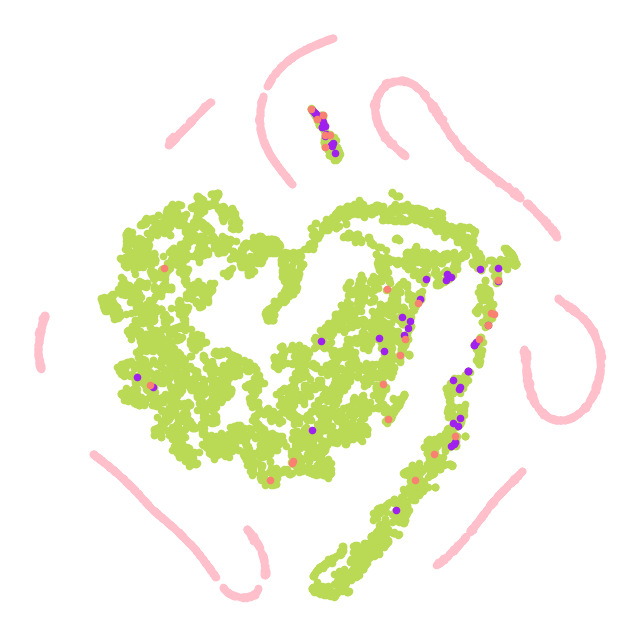

In [ ]:
fig = plt.figure(1, figsize=(8, 8))
fig.clf()
colors = [
    '#ffc0cb', '#bada55', '#A020F0', '#FA8072'
]
idx_fake = [x for x in range(7392, embedded.shape[0])]
idx_real = [x for x in range(7392) if labels[x] == 0]
idx_targets_train = [x for x in idx_train if labels[x] == 1 and x < 7392]
idx_targets_test = [x for x in idx_test if labels[x] == 1 and x < 7392]
plt.scatter(z[idx_fake, 0], z[idx_fake, 1], s=20, color=colors[0])
plt.scatter(z[idx_real, 0], z[idx_real, 1], s=20, color=colors[1])
plt.scatter(z[idx_targets_train, 0], z[idx_targets_train, 1], s=20, color=colors[2])
plt.scatter(z[idx_targets_test, 0], z[idx_targets_test, 1], s=20, color=colors[3])
plt.axis('off')
    
plt.savefig(r'C:\Users\George\Desktop\ISEF-2023\Model\test\ImGAGN\embedded_plot.png', dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    
plt.show()

In [ ]:
df = pd.DataFrame(embedded.detach().numpy())
print(labels)
targets_in_testing = [x for x in idx_test if labels[x] == 1]
print(targets_in_testing, len(targets_in_testing))
labeles = []

for i in range(embedded.shape[0]):
    if i in idx_real:
        labeles.append(0)
    else:
        labeles.append(1)

labeles = np.array(labeles)
df['labels'] = labels

df['protein_name'] = np.nan

# Iterate over the row indices
for i in df.index:
    try:
        # Try to get the 'name' attribute of the node
        node_name = PPI_graph.vs[i]['name']
        df.at[i, 'protein_name'] = node_name
    except IndexError:
        # If the node index does not exist in the graph, it will throw an IndexError
        # We leave the value as NaN in this case
        pass
    
print(df)
csv_filename = r'C:\Users\George\Desktop\ISEF-2023\Model\test\ImGAGN\Embedding.csv'
df.to_csv(csv_filename, index=False)


tensor([0, 0, 0,  ..., 1, 1, 1])
[tensor(3788), tensor(391), tensor(2538), tensor(3817), tensor(2333), tensor(3487), tensor(1334), tensor(5224), tensor(680), tensor(1683), tensor(4884), tensor(3832), tensor(6444), tensor(3884), tensor(6448), tensor(4744), tensor(6665), tensor(6277), tensor(5614), tensor(4328), tensor(976), tensor(6006), tensor(728), tensor(4850), tensor(3874)] 25
             0    1         2         3         4         5         6  \
0     0.222881  0.0  0.227153  0.061117  0.222850  0.391284  0.237098   
1     0.216130  0.0  0.221294  0.062241  0.217980  0.378086  0.231711   
2     0.234109  0.0  0.244737  0.083529  0.239378  0.374946  0.251593   
3     0.223674  0.0  0.228115  0.059576  0.223535  0.398476  0.237992   
4     0.200535  0.0  0.206293  0.064990  0.204471  0.339112  0.216657   
...        ...  ...       ...       ...       ...       ...       ...   
9887  0.042153  0.0  0.041180  0.011819  0.040528  0.052222  0.044182   
9888  0.040084  0.0  0.039162  0.

In [ ]:
from imblearn.over_sampling import SMOTE

fake = [x for x in range(7392, 9892)]
idx_train = np.concatenate((idx_train, np.array(fake)))

training_x = df.iloc[idx_train, :-2]
training_y = df.iloc[idx_train, -2]
testing_x = df.iloc[idx_test, :-2]
testing_y = df.iloc[idx_test, -2]

smote = SMOTE()
#training_x_smote, training_y_smote = smote.fit_resample(training_x, training_y)

analyzing_x = df.iloc[:7392, :-2]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

model = RandomForestClassifier()

# Dictionary to store results
results = {}

# Train and evaluate each model

    # Train the model
model.fit(training_x, training_y)

    # Make predictions
predictions_prob = model.predict_proba(testing_x)
print(np.max(predictions_prob[:, 1]))
predictions_prob = predictions_prob / np.max(predictions_prob[:, 1])
threshold = np.median(predictions_prob[:, 1])
print(threshold)
print(np.sort(predictions_prob[:, 1], axis=0))

#threshold = 0.5

predictions = [1 if prob > threshold else 0 for prob in predictions_prob[:, 1]]
    # Calculate metrics
accuracy = model.score(testing_x, testing_y)
recall = recall_score(testing_y, predictions, zero_division=0)
f1_score_ = f1_score(testing_y, predictions)
precision = precision_score(testing_y, predictions, zero_division=0)
report = classification_report(testing_y, predictions, output_dict=True)
conf_matrix = confusion_matrix(testing_y, predictions)
matthews_coeff = matthews_corrcoef(testing_y, predictions)

    # Store results
results['Random_Forest'] = {
    'Accuracy': accuracy,
    'Recall': recall,
    'Precision': precision,
    'F1 Score': f1_score_,
    'Confusion Matrix': conf_matrix,
    'Matthews Correlation Coefficient': matthews_coeff

}

# You can print the results for each model like this
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

0.46
0.0
[0.         0.         0.         ... 0.91304348 0.97826087 1.        ]
Model: Random_Forest
Accuracy: 0.9887285843101894
Recall: 0.72
Precision: 0.039045553145336226
F1 Score: 0.07407407407407407
Confusion Matrix: [[1750  443]
 [   7   18]]
Matthews Correlation Coefficient: 0.13476508330649362




In [ ]:
pred_prob = model.predict_proba(analyzing_x)

pred_prob[:, 1]
print((np.sort(pred_prob[:, 1], axis=0))[:])

NameError: name 'model' is not defined